在介绍卡尔曼滤波器数学原理之前，先从感性上看一下它的工作原理。
简单来讲，卡尔曼滤波器就是根据上一时刻的状态，预测当前时刻的状态，
将预测的状态与当前时刻的测量值进行加权，加权后的结果才认为是当前的实际状态，而不是仅仅听信当前的测量值。

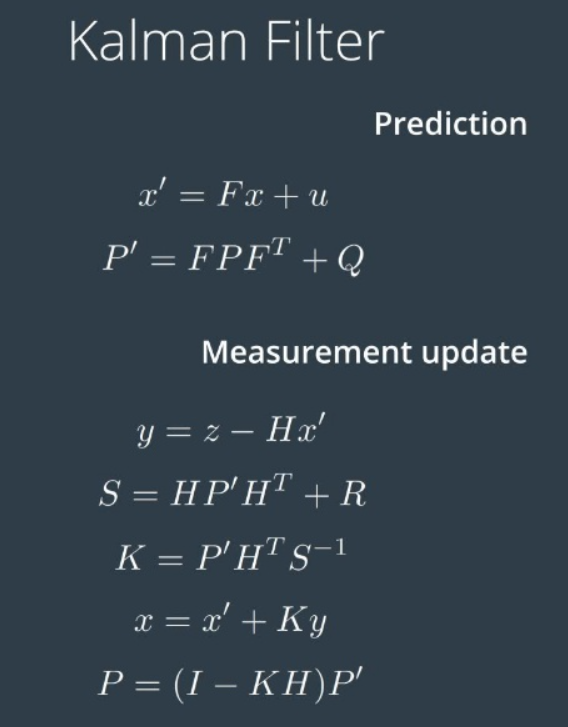

卡尔曼滤波能够从算法的角度提高传感器的测试精度，弱化噪声信号的影响，在航空航天、传感技术、机器人以及控制系统设计等领域具有广泛的应用；调研可知，卡尔曼滤波与FIR滤波器相比，内存占用较小、计算速度快，不需要进行频域转化，能够轻易嵌入数据采集系统，实现信号的准确测量；

  卡尔曼滤波主要的应用场景有：1、系统状态估计：通过传感器间接测量火箭发动机的运行状态，进而计算出药柱燃烧温度等物理参量；2、多源传感器数据融合：如何从多种含有噪声的信号中（GPS、陀螺仪及激光雷达等）确定目标位置；

附1、卡尔曼滤波主要框架？

  卡尔曼滤波的本质属于系统的最优估计，通过卡尔曼增益来修正状态预测值，减小噪声信号对测试精度的影响，其核心内容是基于上一时刻状态的估计值以及当前状态的观测值，给出当前状态的最优估计，该算法涉及的核心方程有：

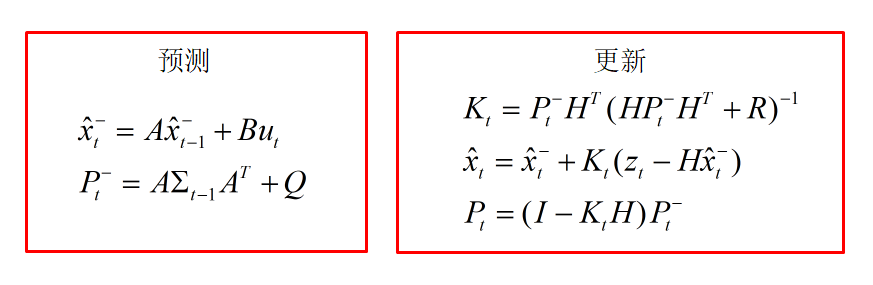

  其中，xt为系统状态矩阵；zt为系统观测矩阵（实验结果）；A为状态转移矩阵；B为控制输入矩阵；H为状态观测矩阵。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 模拟数据
t = np.linspace(1, 100, 100)
a = 0.5
position = (a * t**2) / 2
position_noise = position + np.random.normal(0, 120, size=t.shape[0])

plt.plot(t, position, label="truth position")
plt.plot(t, position_noise, label="only use measured position")

# 初始的估计的位置就直接用GPS测量的位置
predicts = [position_noise[0]]
position_predict = predicts[0]

predict_var = 0
odo_var = 120**2  # 这是我们自己设定的位置测量仪器的方差，越大测量值占比越低
v_std = 50  # 测量仪器的方差

for i in range(1, t.shape[0]):
    dv = position[i] - position[i-1] + np.random.normal(0, 50)  # 模拟从惯性测量单元IMU读取的速度
    position_predict = position_predict + dv  # 利用上个时刻的位置和速度预测当前位置
    predict_var += v_std**2  # 更新预测数据的方差
    # 下面是Kalman滤波
    position_predict = position_predict * odo_var / (predict_var + odo_var) + position_noise[i] * predict_var / (predict_var + odo_var)
    predict_var = (predict_var * odo_var) / (predict_var + odo_var)**2
    predicts.append(position_predict)

plt.plot(t, predicts, label="kalman filtered position")
plt.legend()
plt.show()

# 卡尔曼滤波将噪声值（橙色线），滤波后（绿色线），尽量去拟合原值（蓝色线）

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


"""
X(k) = AX(k-1) + BU(k) + w(k-1)
Z(k) = HX(k) + e(k)
p(w) = N(0, Q)
p(e) = N(0, R)
"""


#一步预测
"""
设状态量有xn个
- X0为前一时刻状态量，shape=(xn,1)
- P0为初始状态不确定度，shape=(xn,xn)
- A为状态转移矩阵，shape=(xn,xn)
- Q为递推噪声协方差矩阵，shape=(xn,xn)
- B、U1是外部输入部分

返回的结果为
- X10为一步预测的状态量结果，shape=(xn,1)
- P10为一步预测的协方差，shape=(xn,xn)
"""
def kf_predict(X0, P0, A, Q, B, U1):
    X10 = np.dot(A,X0) + np.dot(B,U1)
    P10 = np.dot(np.dot(A,P0),A.T)+ Q
    return (X10, P10)


#测量更新
"""
设状态量有xn个
- X10为一步预测的状态量结果，shape=(xn,1)
- P10为一步预测的协方差，shape=(xn,xn)
- Z为观测值，shape=(xn,1)
- H为观测系数矩阵，shape=(xn,xn)
- R为观测噪声协方差，shape=(xn,xn)

返回的结果为
- X1为一步预测的状态量结果，shape=(xn,1)
- P1为一步预测的协方差，shape=(xn,xn)
- K为卡尔曼增益，不需要返回，但是可以看一下它的值来判断是否正常运行
"""
def kf_update(X10, P10, Z, H, R):
    V = Z - np.dot(H,X10)
    K = np.dot(np.dot(P10,H.T),np.linalg.pinv(np.dot(np.dot(H,P10),H.T) + R))
    X1 = X10 + np.dot(K,V)
    P1 = np.dot(np.eye(K.shape[0]) - np.dot(K,H),P10)
    return (X1, P1, K)


"""
加速度白噪声建模
状态方程：
x' = v'
v' = a'
a' = 0 
离散化得到；
x(k) = x(k-1)+t*v(k)+0.5*t^2*a(k)
v(k) = v(k-1)+t*a(k)
a(k) = a(k-1)

观测方程：
z(k) = x(k) + e
"""

n = 20 #数据量
nx = 3 #变量数量
t = np.linspace(0,3,n) #时间序列
dt = t[1] - t[0]

#真实函数关系
a_true = np.ones(n)*9.8 + np.random.normal(0,1,size=n)
v_true = np.cumsum(a_true*dt)
x_true = np.cumsum(v_true*dt)
X_true = np.concatenate([x_true, v_true, a_true]).reshape([nx,-1])

# 观测噪声协方差（可调整）
R = np.diag([10**2])

#仿真观测值
e = np.random.normal(0,2,n)
x_obs = x_true + e

# 计算系数
A = np.array([1,dt,0.5*dt**2,
              0,1,dt,
              0,0,1]).reshape([nx,nx])
B = 0
U1 = 0

#状态假设（观测）初始值
x0 = 0
v0 = 0
a0 = 10.0
X0 = np.array([x0,v0,a0]).reshape(nx,1)

#初始状态不确定度（可调整）
P0 = np.diag([0**2,0**2,0.2**2])

#状态递推噪声协方差（可调整）
Q = np.diag([0.0**2,0**2,1**2])

###开始处理
X1_np = np.copy(X0)
P1_list = [P0]
X10_np = np.copy(X0)
P10_list = [P0]

for i in range(n):
    Zi = np.array(x_obs[i]).reshape([1,1])
    Hi = np.array([1,0,0]).reshape([1,nx])
    
    if (i == 0):
        continue
    else:
        Xi = X1_np[:,i-1].reshape([nx,1])
        Pi = P1_list[i-1]
        X10, P10 = kf_predict(Xi, Pi, A, Q, B, U1)

        X10_np = np.concatenate([X10_np, X10], axis=1)
        P10_list.append(P10)

        X1, P1, K = kf_update(X10, P10, Zi, Hi, R)
        X1_np = np.concatenate([X1_np, X1], axis=1)
        P1_list.append(P1)

#结束，绘图
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_true, 'k-', label="Truth")
ax1.plot(X1_np[0,:], 'go--', label="Kalman Filter")
ax1.scatter(np.arange(n), x_obs, label="Observation", marker='*')

plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from filterpy.kalman import KalmanFilter  # 与torch冲突，导致torch无法导入，所以如果两个需要同时使用的话需要先导入torch


# 小车运动数据生成

z = np.linspace(1, 1000, 1000)  # 小车实际位置
mu, sigma = 0, 1
noise = np.random.normal(mu, sigma, 1000)  # 噪声
z_noise = z + noise  # 小车位置的观测值

# 卡尔曼滤波器参数初始化

# dim_x: 状态向量size，在该例中为[p, v]，即位置和速度，size=2
# dim_z: 测量向量size，假设小车为匀速，速度为1，测量向量只观测位置，size=1
my_filter = KalmanFilter(dim_x=2, dim_z=1)
# x: 初始状态为[0, 0]，即初始位置为0，速度为0
# 这个初始值不是非常重要，在利用观测值进行迭代更新后接近于真实值
my_filter.x = np.array([[0.], [0.]])
# P: 协方差矩阵，表示状态向量内位置与速度的相关性
# 假设速度与位置没关系，协方差矩阵为[[1, 0], [0, 1]]
my_filter.P = np.array([[1., 0.], [0., 1.]])
# F: 初始的状态转移矩阵，假设为匀速运动模型，可将其设为如下
my_filter.F = np.array([[1., 1.], [0., 1.]])
# Q: 状态转移协方差矩阵，也就是外界噪声
# 在该例中假设小车为匀速，外界干扰小，所以我们对F非常确定，觉得F一定不会出错，所以Q设的很小
my_filter.Q = np.array([[0.0001, 0.], [0., 0.0001]])
# H: 观测矩阵
# 利用观测数据对预测进行更新，观测矩阵的左边一项不能设置为0
my_filter.H = np.array([[1, 0]])
# R: 测量噪声协方差矩阵，方差为1
my_filter.R = 1
# 更新过程中不会发生变化的是：F Q H R

# 利用卡尔曼滤波进行预测

# 保存卡尔曼滤波过程中的位置和速度
z_new_list = []
v_new_list = []
# 对于每一个观测值进行一次卡尔曼滤波
for k in range(len(z_noise)):
    my_filter.predict()  # 预测
    my_filter.update(z_noise[k])  # 利用观测值进行更新
    x = my_filter.x  # 输出结果
    # 收集卡尔曼滤波后的速度和位置信息
    z_new_list.append(x[0][0])
    v_new_list.append(x[1][0])

# 位置的偏差
z_diff_list = []
for k in range(len(z)):
    z_diff_list.append(z_new_list[k] - z[k])
# 速度的偏差
v_diff_list = []
for k in range(len(z)):
    v_diff_list.append(v_new_list[k] - 1)

# 概率密度函数
# 为了验证卡尔曼滤波的结果优于测量的结果，绘制预测结果误差和测量误差的概率密度函数
z_noise_std_list = np.std(noise)
# z_noise_mean_list = np.mean(noise)
z_filtered_std_list = np.std(z_diff_list)
plt.figure(figsize=(16, 8))
ax = sns.kdeplot(noise, shade=True, color="r", label="std=%.3f" % z_noise_std_list)
ax = sns.kdeplot(z_diff_list, shade=True, color="g", label="std=%.3f" % z_filtered_std_list)
# 从图中可以看出，卡尔曼滤波预测的结果误差方差更小，优于测量结果。